In [1]:

import os, sys
sys.path.append('..')

import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
from tqdm import tqdm
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import numpy as np


from optimize_ds import load_chunk, mmap_dask_array

    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


In [2]:
df = pd.read_parquet('analysis.parquet.gzip')  
df

longest_match  overlap  lev  diff       0  10  20  30  \
index    checkpoint                                                          
10240000 10000                   0        9   53   3.0  475130   1   1   1   
         11000                   0        7   56  -1.0  476660   0   0   0   
         12000                   0        8   55   0.0  475581   0   0   0   
         13000                   0        8   55   4.0  476449   0   0   0   
         14000                   0        4   59  -3.0  477157   0   0   0   
...                            ...      ...  ...   ...     ...  ..  ..  ..   
11263980 15000                   7        7   54   1.0  358855   0   0   0   
         16000                   7        7   55   0.0  358432   0   0   0   
         17000                   7        8   55   1.0  358371   0   0   0   
         18000                   7        7   56  -3.0  359408   0   0   0   
         19000                   7        8   53   3.0  345345   0   0   0   

                     40  50  ...  180  190  200  210  220  230  240  250  \
index    checkpoint          ...                                           
10240000 10000        1   1  ...    1    1    1    1    1    1    1    1   
         11000        0   0  ...    0    0    0    0    0    0    0    0   
         12000        0   0  ...    0    0    0    0    0    0    0    0   
         13000        0   0  ...    0    0    0    0    0    0    0    0   
         14000        0   0  ...    0    0    0    0    0    0    0    0   
...                  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11263980 15000        0   0  ...    0    0    0    0    0    0    0    0   
         16000        0   0  ...    0    0    0    0    0    0    0    0   
         17000        0   0  ...    0    0    0    0    0    0    0    0   
         18000        0   0  ...    0    0    0    0    0    0    0    0   
         19000        0   0  ...    0    0    0    0    0    0    0    0   

                     complexity  cumsum30  
index    checkpoint                        
10240000 10000         0.593750         1  
         11000         0.593750         1  
         12000         0.593750         1  
         13000         0.593750         1  
         14000         0.593750         1  
...                         ...       ...  
11263980 15000         0.538194         1  
         16000         0.538194         1  
         17000         0.538194         1  
         18000         0.538194         1  
         19000         0.538194         1  

[512000 rows x 32 columns]

In [3]:
num_select = 500

maxvals = df.groupby(df.index.get_level_values(0)).transform('max') 
indices_0_1 = np.array(list(set(df[(df["longest_match"] < 5 ) & (df.index.get_level_values(-1) == 10000)].index.get_level_values(0).to_numpy()).intersection(
    set(df[(maxvals["longest_match"] > 10) & (maxvals["cumsum30"] < 10)].index.get_level_values(0).to_numpy()))))
indices_0_0 = np.array(list(set(df[(df["longest_match"] < 5 ) & (df.index.get_level_values(-1) == 10000)].index.get_level_values(0).to_numpy()).intersection(
    set(df[maxvals["longest_match"] <= 10].index.get_level_values(0).to_numpy()))))
print(len(indices_0_1))
indices_0_0 = indices_0_0[np.random.choice(len(indices_0_0), len(indices_0_1))]
# indices_0_1 = indices_0_1[np.random.choice(len(indices_0_1), 500)]

308


In [359]:
df[df.index.get_level_values(0) == indices_0_1[2]]

longest_match  overlap  diff       0  10  20  30  40  50  \
index    checkpoint                                                             
10686980 10000                   0       87   0.0  687577   1   1   1   1   1   
         11000                   0       87  21.0  687979   0   0   0   0   0   
         12000                  21       90 -21.0  688334   0   0   0   0   0   
         13000                   0       87  21.0  687589   0   0   0   0   0   
         14000                  21       90   0.0  687944   0   0   0   0   0   
         15000                  21       90 -21.0  687825   0   0   0   0   0   
         16000                   0       87  21.0  687896   0   0   0   0   0   
         17000                  21       90   0.0  688536   0   0   0   0   0   
         18000                  21       90   0.0  688401   0   0   0   0   0   
         19000                  21       90 -21.0  660879   0   0   0   0   0   

                     60  ...  180  190  200  210  220  230  240  250  \
index    checkpoint      ...                                           
10686980 10000        1  ...    1    1    1    1    1    1    1    1   
         11000        0  ...    0    0    0    0    0    0    0    0   
         12000        0  ...    0    0    0    0    0    0    0    0   
         13000        0  ...    0    0    0    0    0    0    0    0   
         14000        0  ...    0    0    0    0    0    0    0    0   
         15000        0  ...    0    0    0    0    0    0    0    0   
         16000        0  ...    0    0    0    0    0    0    0    0   
         17000        0  ...    0    0    0    0    0    0    0    0   
         18000        0  ...    0    0    0    0    0    0    0    0   
         19000        0  ...    0    0    0    0    0    0    0    0   

                     complexity  cumsum30  
index    checkpoint                        
10686980 10000         0.149306         1  
         11000         0.149306         1  
         12000         0.149306         1  
         13000         0.149306         1  
         14000         0.149306         1  
         15000         0.149306         1  
         16000         0.149306         1  
         17000         0.149306         1  
         18000         0.149306         1  
         19000         0.149306         1  

[10 rows x 31 columns]

In [244]:
all_indices = np.concatenate([indices_0_1, indices_0_0])
data = np.array([dataset[idx.astype(np.int32).item()] for idx in all_indices])

In [263]:
MODEL='1b-v0'
CHECKPOINT=10000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).half().eval().cuda()

In [264]:
dataset = MMapIndexedDataset('/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document', skip_warmup = True)
tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="/om/user/sunnyd/transformers_cache",
)
idx = 10835120
idx = 10240440
# idx = 18
# context_tokens = torch.tensor([dataset[idx][:32].astype(np.int32)]).to('cuda')
context_tokens = torch.tensor(data[:, :32].astype(np.int32)).to('cuda')
with torch.no_grad():
        gen_orig = model.generate(context_tokens.cuda(), temperature = 0.0, top_k = 0, top_p = 0, max_length = 288, min_length = 288)
tokenizer.decode(dataset[idx][:32])

    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


' an int variable in which to store the value of the flag.\nfunc (f *FlagSet) IntVar(p *int, name string, value'

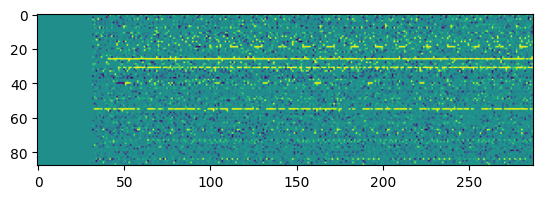

In [265]:
plt.imshow(gen_orig.cpu().numpy() - data[:, :288])

In [266]:
# add edit distance instead
# Write outline for paper


In [267]:
tokenizer.decode(dataset[idx][32:288])

' int, usage string) {\n\tf.VarP(newIntValue(value, p), name, "", usage)\n}\n\n// IntVarP is like IntVar, but accepts a shorthand letter that can be used after a single dash.\nfunc (f *FlagSet) IntVarP(p *int, name, shorthand string, value int, usage string) {\n\tf.VarP(newIntValue(value, p), name, shorthand, usage)\n}\n\n// IntVar defines an int flag with specified name, default value, and usage string.\n// The argument p points to an int variable in which to store the value of the flag.\nfunc IntVar(p *int, name string, value int, usage string) {\n\tCommandLine.VarP(newIntValue(value, p), name, "", usage)\n}\n\n// IntVarP is like IntVar, but accepts a shorthand letter that can be used after a single dash.\nfunc IntVarP(p *int, name, shorthand string, value int, usage string) {\n\tCommandLine.VarP(newIntValue(value, p), name,'

In [268]:
tokenizer.decode(gen_orig[0][32:])

'2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-26-1-116-14){ref-type="table-fn"}   0.81[^a^](#tfn2-ajas-'

In [269]:
gen_orig[0][32:].cpu() - dataset[idx][32:288]

tensor([  -521,      1,  33381,  -2862,   1721,   -537,   -169,   -172,  13139,
            -1, -12201,    861,    700,  -1812,  -3926,  -3334,   2411,  -2863,
          4161,    718,  49693,  -1399,      2, -14993,  -5213,     56,  17091,
         24656,   -168,   -173,  43169,  -4444, -11517,    -35,   -292,   -737,
          8752, -13234,   1034,    377, -24317,   -233, -45838,    173,  -2437,
          -312,   3698,    666,  49367,   -829,   -232,   1579, -14954,     51,
         17091,  19753,   -294,    -57,  43299, -22518,  -2800,      4,  -4440,
        -13234,  13161,      5,    966,    435,    144,      1,   -535,    555,
        -44299,   -381,   1298,    973,  48957,   -523,      2,  -6800,   2304,
            56,  16727,  24563,   -167,    -57,  43759, -13234,   1682,      5,
         -1808,  -4793,   9308,      5,  -1830,    897,    441,   -568,   -535,
           555, -44299,   -381,   4161,  -9407,  50265,   -170,    -79,   3406,
          4993,   -539,  12820,  11502, 

In [297]:
from tqdm.notebook import tqdm
model2 = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).half().eval().cuda()

param1 = dict(model.named_parameters())
gens = []
for i in tqdm(range(200)):
    with torch.no_grad():
        for k, p2 in model2.named_parameters():
            p2.copy_(param1[k] + torch.randn_like(p2) * 4e-4)
    with torch.no_grad():
        gen = model2.generate(context_tokens.cuda(), temperature = 0.0, top_k = 0, top_p = 0, max_length = 288, min_length = 288)
        gens.append(gen.detach().cpu().numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attentio

In [301]:
results = np.stack(gens)

In [315]:
diff = 250 - np.min(np.sum((results - data[:, :288] != 0), -1), 0)

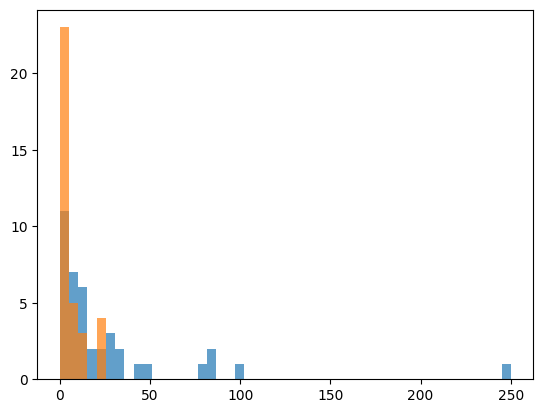

In [316]:
plt.hist(diff[:44], bins=np.linspace(0, 250, 50), alpha=0.7);
plt.hist(diff[44:], bins=np.linspace(0, 250, 50), alpha=0.7);

In [155]:
(gen - gen_orig).abs()[0, 32:]

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 14373,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1296,     0,     0,     0,     0,     0,  7178,
        10034,    26,  1767,  1718,   260, 13440,  2001,  5893, 13468, 10433,
         1741,  5925, 31960,   211,  1996,  6162,   254,   231,  1994,  1000,
            2,     0,  4507,  4612,     0, 23047,  1580,  3450,    86,    60,
         1845,  3481, 20979,    60,  1827, 18545,  2923,   232,  1692,  5178,
         4419,   234,  1827,  5991,  8125,   121,  1691, 23137, 

In [156]:
(gen[0][32:].cpu() - dataset[idx][32:288]).abs()

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          722,  5626,     0,     0,     0,     0,     0,     0,     0,     0,
          192,     0,  1356, 21770,   136,   169,   136, 41100, 48113,  8206,
         7867,   260, 12573,  4175,  2885, 13414,   234, 40949, 13727,  9065,
          259,  2093, 26696,  5334,   305,  5217,  1775,   567,  1895,  6764,
           10, 16282,  3104,  2757,    86, 23107,  3425,    31, 21065,     0,
         3672, 22026, 18056,   172,  3547, 18077,  3183,   172,   135,  7398,
         4324,   310, 29128,   447,   684,    87, 10865, 26618, 